# Compare CB1r between HC and PTSD

first collect data from HC and PTSD

In [1]:
import pandas as pd
from glob import glob

In [2]:
hc_path = '/media/Data/Lab_Projects/CB1/neuroimaging/CB1_results/OMAR_scores/dcd/HC/*/batch_omar_doneon_*.csv'

db = pd.DataFrame()

for sub in glob(hc_path):
    temp = pd.read_csv(sub)
    temp = temp[temp['Parameter']== 'VT']
    subID = temp.PatientID[0]
    temp = temp[['ROI', 'Value']]
    temp = temp.rename(columns={'Value': subID})
    temp = temp.set_index('ROI')
    temp = temp.T
    db = db.append(temp)
    
db['group'] = 'HC'

In [3]:
PTSD = pd.read_csv('/home/nachshon/Documents/CB1/PETdata/CB1_clinical_30_6_21.csv')
PTSD = PTSD[PTSD['PTSD'] == 'Yes']
PTSD = PTSD.set_index('PetID')
PTSD_bg = PTSD.iloc[:, 11:]
PTSD_bg['group'] = 'PTSD'
db = db.append(PTSD_bg)

### Check for data normality

In [4]:
from scipy import stats

In [5]:
shapiro = pd.DataFrame()
for col in range(db.shape[-1]-1):
    temp = stats.shapiro(db.iloc[:,col])
    if temp.pvalue < 0.05:
        print(db.iloc[:,col].name)

Data is normal

### Check for intercorrelation between brain regions

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
db_cor = db.iloc[:, :-2]

In [8]:
corrMatrix = db_cor.corr()

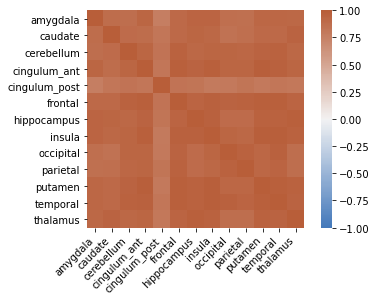

In [9]:
ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 25, n=250),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Things are intercorrelated!

now add age and gender

In [10]:
age = pd.read_csv('/home/nachshon/Documents/CB1/PETdata/age.csv')
age = age.set_index('PatientID')
data = db.merge(age , left_index=True, right_index=True)

### run ANCOVA

In [11]:
import pingouin as pg
import numpy as np
import statsmodels.formula.api as smf

/home/nachshon/anaconda3/envs/cb1scr/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nachshon/anaconda3/envs/cb1scr/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [12]:
data['sexint'] = np.where(data['sex'] == "f", 0, 1)

In [13]:
pg.ancova(data=data, dv='amygdala', covar=['age', 'sexint'], between='group')

,Source,SS,DF,F,p-unc,np2
0,group,0.379373,1,4.913193,0.033882,0.133101
1,age,0.216931,1,2.809439,0.103456,0.080709
2,sexint,0.026942,1,0.348926,0.558871,0.010786
3,Residual,2.470887,32,NaN,NaN,NaN


In [14]:
mod = smf.ols(formula='amygdala ~ C(group) + age + C(sex)', data=data)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               amygdala   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     4.612
Date:                Thu, 30 Sep 2021   Prob (F-statistic):            0.00488
Time:                        16:42:45   Log-Likelihood:                -2.5829
No. Observations:                  36   AIC:                             15.17
Df Residuals:                      31   BIC:                             23.08
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0741      0.297  

### Plot the differance

In [15]:
sns.set(style="whitegrid",font_scale=2)
import matplotlib.collections as clt
import ptitprince as pt
import statsmodels.api as sm

Text(0.5, 1.0, 'Raw Amygdala Vt')

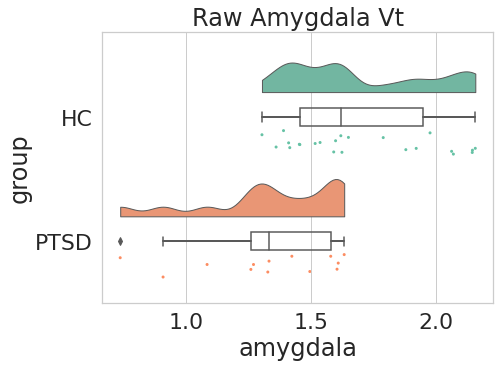

In [16]:
dx = "group"
dy = "amygdala"
ort = "h"
pal = "Set2"
sigma = .2

f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x = dx, y = dy, data = data, palette = pal,
      bw = sigma, width_viol = .6, ax = ax, orient = ort, move = .2)
plt.title("Raw Amygdala Vt")

Get residuals amygdala-age

In [17]:
x = data['amygdala']
z = data['age']

x = sm.add_constant(x)
model = sm.OLS(z, x).fit() 
influence = model.get_influence()

data['Amygdala'] = influence.resid_studentized_internal

Text(0.5, 1.0, 'Amygdala Vt controlled for sex')

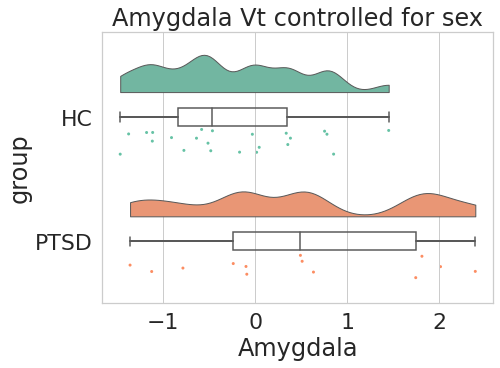

In [18]:
dx = "group"
dy = "Amygdala"
ort = "h"
pal = "Set2"
sigma = .2

f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x = dx, y = dy, data = data, palette = pal,
      bw = sigma, width_viol = .6, ax = ax, orient = ort, move = .2)
plt.title("Amygdala Vt controlled for sex")

get rsiduals for amygdala -[age, sex]

In [19]:
X = data[['sexint', 'age']]   # independent variables
y = data['amygdala']   # dependent variables

# to get intercept -- this is optional
X = sm.add_constant(X)

# fit the regression model
model = sm.OLS(y, X).fit() 
influence = model.get_influence()

data['Amygdala2'] = influence.resid_studentized_internal

Text(0.5, 1.0, 'Amygdala Vt controlled for age and sex')

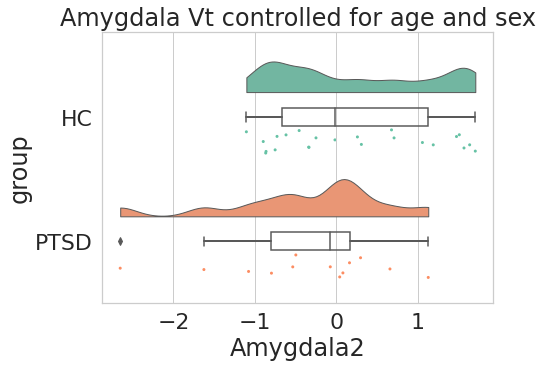

In [20]:
dx = "group"
dy = "Amygdala2"
ort = "h"
pal = "Set2"
sigma = .2

f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x = dx, y = dy, data = data, palette = pal,
      bw = sigma, width_viol = .6, ax = ax, orient = ort, move = .2)
plt.title("Amygdala Vt controlled for age and sex")